### Play with different custom arch's

Some notes:
 - topleft is still a difficult problem.
 - center is relatively well modelled.

In [2]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

In [3]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)


In [91]:
net3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )

In [92]:
net3_tl = Learner(
                    dl_1_topleft, 
                     net3, 
                     loss_func=MSELossFlat(), 
                     metrics=[mae, R2Score()],
                    )

net3_cnt = Learner(
                    dl_1_center, 
                     net3, 
                     loss_func=MSELossFlat(), 
                     metrics=[mae, R2Score()],
                    )

In [128]:
q = cnn_learner(net3_tl, resnet18, )

AttributeError: 'Learner' object has no attribute 'train'

In [93]:
net3_tl.fit(20)

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.118929,0.037248,0.147627,0.268793,00:02
1,0.078591,0.046438,0.179780,0.088401,00:01
2,0.064072,0.037104,0.155806,0.271638,00:01
3,0.052890,0.025285,0.115933,0.503642,00:01
4,0.044521,0.026186,0.121323,0.485952,00:01
5,0.038762,0.022590,0.109427,0.556555,00:01
6,0.034306,0.023087,0.112628,0.546798,00:01
7,0.030936,0.021278,0.107801,0.582309,00:01
8,0.028000,0.020550,0.104415,0.596586,00:01
9,0.025680,0.020197,0.103271,0.603525,00:01


In [59]:
net3_cnt.fit(20)

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.113094,0.040044,0.158461,-2.442195,00:01
1,0.078911,0.027261,0.128437,-1.343392,00:01
2,0.057021,0.018507,0.109754,-0.590842,00:01
3,0.044612,0.009905,0.074315,0.148540,00:01
4,0.035545,0.009183,0.069752,0.210606,00:01
5,0.029113,0.006292,0.059152,0.459147,00:01
6,0.024252,0.005383,0.054889,0.537281,00:01
7,0.020446,0.004918,0.053384,0.577255,00:01
8,0.017422,0.004285,0.050129,0.631659,00:01
9,0.014973,0.003898,0.047758,0.664956,00:01


In [26]:
def pva_plot(actuals, predicts, title=''):
    plt.scatter(actuals, predicts, alpha=0.4)
    y0, y1 = plt.ylim()
    x0, x1 = plt.xlim()
#     full_area = [min(x0, y0), max(x1, y1)]
#     plt.plot(full_area, full_area, linestyle='--')
#     plt.xlabel('Actual'); plt.ylabel('Predicted');
#     plt.title(f'{title} - Predicted vs Actual');

In [81]:
def pva_plot_2(preds, title=''):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    coord_name = ('X','Y')
    
    for i in range(2):
        
        actuals =  preds[1].view(-1,2)[:,i]
        predicts = preds[0][:,i]
        
        ax[i].scatter(actuals, predicts, alpha=0.4)
        
        y0, y1 = ax[i].get_ylim()
        x0, x1 = ax[i].get_xlim()
        full_area = [min(x0, y0), max(x1, y1)]
        ax[i].plot(full_area, full_area, linestyle='--')
        ax[i].set_xlabel('Actual'); ax[i].set_ylabel('Predicted');
        ax[i].set_title(f'{coord_name[i]} coord')
        
    fig.suptitle(f'{title} - PvA');

mse: 0.002413687761873007


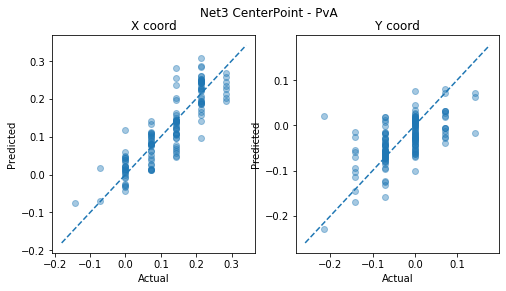

In [89]:
preds = net3_cnt.get_preds()
print(f'mse: {mse(preds[0],preds[1])}')
pva_plot_2(preds, 'Net3 CenterPoint')

mse: 0.019447995349764824


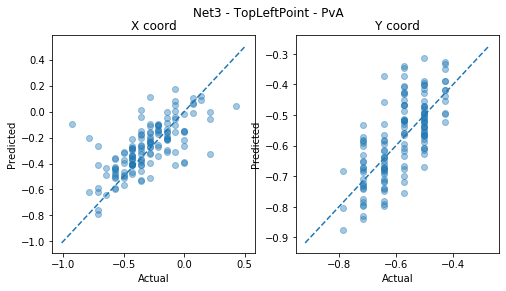

In [94]:
preds = net3_tl.get_preds()
print(f'mse: {mse(preds[0],preds[1])}')
pva_plot_2(preds, 'Net3 - TopLeftPoint')

In [95]:
net4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=28,),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )

net5 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=28,),
            nn.Linear(in_features=28, out_features=28,),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )

In [97]:
net4_tl = Learner(
                     dl_1_topleft, 
                     net4, 
                     loss_func=MSELossFlat(), 
                     metrics=[mae, R2Score()],
                    )

net5_tl = Learner(
                     dl_1_topleft, 
                     net5, 
                     loss_func=MSELossFlat(), 
                     metrics=[mae, R2Score()],
                    )

In [98]:
net4_tl.fit(20)

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.120258,0.037776,0.149442,0.258443,00:01
1,0.078040,0.042037,0.168666,0.174795,00:01
2,0.062554,0.031235,0.138033,0.386848,00:01
3,0.051291,0.024262,0.111768,0.523729,00:01
4,0.043607,0.026403,0.120822,0.481698,00:01
5,0.038049,0.022048,0.104847,0.567178,00:01
6,0.033898,0.023242,0.111733,0.543752,00:01
7,0.030445,0.020564,0.101331,0.596323,00:01
8,0.027757,0.022205,0.108197,0.564107,00:01
9,0.025516,0.020019,0.101878,0.607011,00:01


In [99]:
net5_tl.fit(20)

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.139557,0.060704,0.195260,-0.191651,00:01
1,0.089876,0.042127,0.158543,0.173032,00:01
2,0.071569,0.029545,0.128530,0.420017,00:01
3,0.058955,0.029771,0.130299,0.415584,00:01
4,0.050413,0.023887,0.109780,0.531080,00:01
5,0.043674,0.022854,0.106606,0.551357,00:01
6,0.038627,0.022254,0.104653,0.563149,00:01
7,0.034727,0.020825,0.099912,0.591191,00:01
8,0.031496,0.019995,0.099490,0.607482,00:01
9,0.028692,0.019468,0.096617,0.617837,00:01


In [100]:
preds = [
    net3_tl.get_preds(),
    net4_tl.get_preds(),
    net5_tl.get_preds(),
]

In [101]:
[mse(pred, actual) for pred,actual in preds]

[tensor(0.0194), tensor(0.0208), tensor(0.0165)]

In [108]:
rec = net4_tl.cbs[1]

In [112]:
rec.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Flatten              64 x 784             0          False     
________________________________________________________________
Linear               64 x 28              21,980     True      
________________________________________________________________
Linear               64 x 28              812        True      
________________________________________________________________
Linear               64 x 2               56         True      
________________________________________________________________
SigmoidRange         64 x 2               0          False     
________________________________________________________________

Total params: 22,848
Total trainable params: 22,848
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f444299ff80>
Loss function: FlattenedLoss of MSELoss()

Model unfrozen

Callbacks:
  - TrainEvalCallback
  - Recorder
  - P

In [105]:
[mae(pred, actual) for pred,actual in preds]

[tensor(0.0985), tensor(0.1011), tensor(0.0829)]

In [119]:
tmp = R2Score()

In [121]:
tmp.func(p, a)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [113]:
from sklearn.metrics import r2_score
[r2_score(pred.tolist(), actual.tolist()) for pred,actual in preds]

ValueError: Found array with dim 3. Estimator expected <= 2.

In [115]:
ret = preds[0]

In [116]:
len(ret)

2

In [117]:
p, a = ret

In [118]:
p.shape

torch.Size([141, 2])